 # Evaluate RAG with Online Inference

In this tutorial, we demonstrate how to evaluate a Retrieval-Augmented Generation (RAG) pipeline using an online inference approach. You will learn how to use a deployed LLM service to process evaluation queries, retrieve supporting context, and generate responses.

Here is the architecture diagram for the RAG evaluation pipeline with online inference:

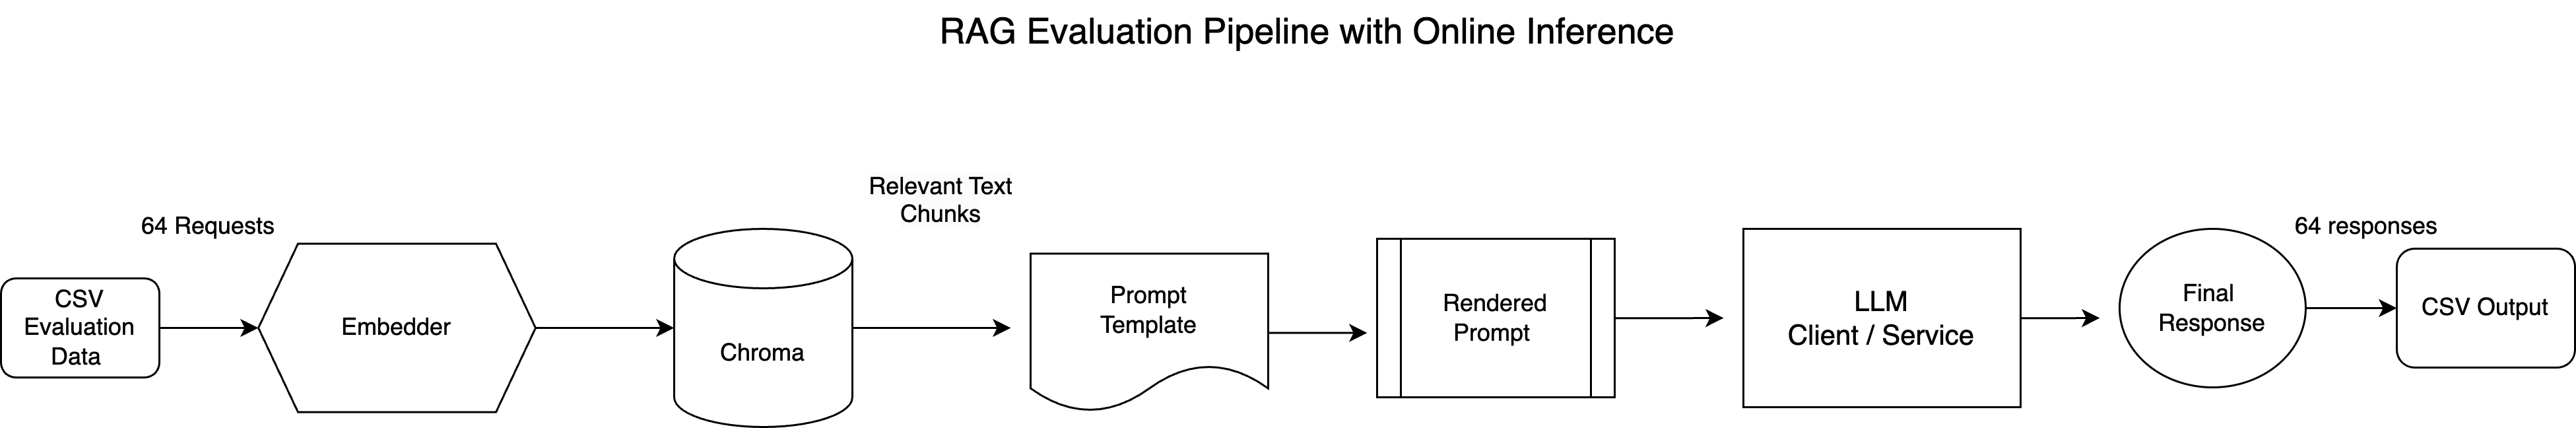

<div class="alert alert-block alert-warning">
  <b>Anyscale-Specific Configuration</b>
  
  <p>Note: This tutorial is optimized for the Anyscale platform. When running on open source Ray, additional configuration is required. For example, you’ll need to manually:</p>
  
  <ul>
    <li>
      <b>Configure your Ray Cluster:</b> Set up your multi-node environment (including head and worker nodes) and manage resource allocation (e.g., autoscaling, GPU/CPU assignments) without the Anyscale automation. See the Ray Cluster Setup documentation for details: <a href="https://docs.ray.io/en/latest/cluster/getting-started.html">https://docs.ray.io/en/latest/cluster/getting-started.html</a>.
    </li>
    <li>
      <b>Manage Dependencies:</b> Install and manage dependencies on each node since you won’t have Anyscale’s Docker-based dependency management. Refer to the Ray Installation Guide for instructions on installing and updating Ray in your environment: <a href="https://docs.ray.io/en/latest/ray-core/handling-dependencies.html">https://docs.ray.io/en/latest/ray-core/handling-dependencies.html</a>.
    </li>
    <li>
      <b>Set Up Storage:</b> Configure your own distributed or shared storage system (instead of relying on Anyscale’s integrated cluster storage). Check out the Ray Cluster Configuration guide for suggestions on setting up shared storage solutions: <a href="https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html">https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html</a>.
    </li>
  </ul>

</div>


## Prerequisites

Before you move on to the next steps, please make sure you have all the required prerequisites in place.


<div class="alert alert-block alert-warning"> <b> Pre-requisite #1: You must have finished the data ingestion in Chroma DB with CHROMA_PATH = "/mnt/cluster_storage/vector_store" and CHROMA_COLLECTION_NAME = "anyscale_jobs_docs_embeddings". For setup details, please refer to Notebook #2.</b> 
<div>

<div class="alert alert-block alert-warning"> <b> Pre-requisite #2: You must have deployed the LLM service with `Qwen/Qwen2.5-32B-Instruct` model. For setup details, please refer to Notebook #3.</b> 
<div>

## Initlize the RAG components

First,  initializing the necessary components:

* **Embedder**: Converts your questions into a embedding the system can search with.
* **ChromaQuerier**: Searches our document chunks for matches using the vector DB Chroma.
* **LLMClient**: Sends questions to the language model and gets answers back.

In [ ]:
from rag_utils import  Embedder, LLMClient, ChromaQuerier, render_rag_prompt

EMBEDDER_MODEL_NAME = "intfloat/multilingual-e5-large-instruct"
CHROMA_PATH = "/mnt/cluster_storage/vector_store"
CHROMA_COLLECTION_NAME = "anyscale_jobs_docs_embeddings"


# Initialize client
model_id='Qwen/Qwen2.5-32B-Instruct' ## model id need to be same as your deployment 
base_url = "https://llm-service-qwen-32b-jgz99.cld-kvedzwag2qa8i5bj.s.anyscaleuserdata.com/" ## replace with your own service base url
api_key = "a1ndpMKaXi76sTIfr_afmx8HynFA1fg-TGaZ2gUuDG0" ## replace with your own api key


# Initialize the components for rag.
querier = ChromaQuerier(CHROMA_PATH, CHROMA_COLLECTION_NAME, score_threshold=0.8)
embedder = Embedder(EMBEDDER_MODEL_NAME)
llm_client = LLMClient(base_url=base_url, api_key=api_key, model_id=model_id)

## Load the Evaluation Data

The evaluation data is stored in a CSV file (`evaluation_data/rag-eval-questions.csv`) that contains 64 user queries grouped by category. 

These queries cover a range of topics—from technical questions about Anyscale and its relationship with Ray, to casual, ethically sensitive, and non-English requests. This diverse dataset helps assess the system's performance on a wide variety of inputs.

Feel free to add more categories or questions as needed.

In [ ]:
import pandas as pd


# Load questions from CSV file
csv_file = "evaluation_data/rag-eval-questions.csv"  # Ensure this file exists in the correct directory
df = pd.read_csv(csv_file)

print("first 5 rows:\n\n", df.head(5))



first 5 rows:

            category                                       user_request
0  anyscale-general        what is the difference btw anyscale and ray
1  anyscale-general   What is Anyscale, and how does it relate to Ray?
2  anyscale-general  How does Anyscale simplify running Ray applica...
3  anyscale-general                                  What is Anyscale?
4  anyscale-general                            How does Anyscale work?


## Evaluate the RAG Pipeline Using Online Inference

This section shows how to use online inference with the deployed LLM service to evaluate the RAG system. Although this method is straightforward, it might be slow for large datasets. Online inference is best suited for smaller datasets during initial evaluations.

In [ ]:


def eval_rag(df, output_csv="eval_results.csv", num_requests=None):
    """
    Process each row in the DataFrame, obtain answers using the LLM client, and save the results to a CSV file.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'category' and 'user_request' columns.
        output_csv (str): The file path to save the CSV results.
        num_requests (int, optional): Number of requests to evaluate. If None, all requests will be evaluated.
    """
    responses = []
    
    # If num_requests is specified, limit the DataFrame to that number of rows.
    if num_requests is not None:
        df = df.head(num_requests)
    
    for idx, row in df.iterrows():
        category = row['category']
        user_request = row['user_request']
        
        # Print the evaluation statement for the user request.
        print(f"Evaluating user request #{idx}: {user_request}")
        
        chat_history = ""
        company = "Anyscale"
        
        # Query for context
        user_request_embedding = embedder.embed_single(user_request)
        context = querier.query(user_request_embedding, n_results=10)
        
        # Create prompt using render_rag_prompt.
        prompt = render_rag_prompt(company, user_request, context, chat_history)
        
        # Get the answer from the chat model client.
        answer = llm_client.get_response(prompt, temperature=0)
        
        responses.append({
            "Category": category,
            "User Request": user_request,
            "Context": context,
            "Answer": answer
        })
    
    # Convert responses to DataFrame and save as CSV
    output_df = pd.DataFrame(responses)
    output_df.to_csv(output_csv, index=False)
    print(f"CSV file '{output_csv}' has been created with questions and answers.")


In [ ]:
eval_rag(df, output_csv="eval_results_online_inference_qwen32b.csv")

Evaluating user request #0: what is the difference btw anyscale and ray
Evaluating user request #1: What is Anyscale, and how does it relate to Ray?
Evaluating user request #2: How does Anyscale simplify running Ray applications?
Evaluating user request #3: What is Anyscale?
Evaluating user request #4: How does Anyscale work?
Evaluating user request #5: What is the difference between open-source Ray and Anyscale’s Ray Serve?
Evaluating user request #6: How much does Anyscale cost?
Evaluating user request #7: What are Anyscale Workspaces?
Evaluating user request #8: Does Anyscale support multi-cloud deployments?
Evaluating user request #9: What is Anyscale Credit?
Evaluating user request #10: What are the key benefits of Anyscale?
Evaluating user request #11: How does Anyscale optimize compute resources?
Evaluating user request #12: is there a way in my Ray Code to mark a node in an Anyscale Cluster as unhealthy such that Anyscale will restart it?
Evaluating user request #13: How can I 

## Evaluate the Results and Improve RAG Quality

After running the evaluation, open the resulting CSV file (`eval_results_online_inference.csv`) to review:

* The user request.
* The retrieved context from the vector store.
* The generated answer from the LLM service.

You can manually review the evaluation results, marking responses as good or bad, and refine the prompt iteratively to improve performance.

Save the high-quality responses as a golden dataset for future reference. Once you have a substantial golden dataset, you can leverage more advanced LLMs—potentially with reasoning capabilities—to act as an **LLM judge**, comparing new RAG results against the golden dataset.

## Scalability Considerations: Why Online Inference May Not Be Ideal

While online inference is simple to implement, it has limitations for large-scale evaluations:

* **Production Stability**: High-volume requests can overload the production LLM API, potentially affecting service stability.
* **Overhead**: Deploying a dedicated evaluation service adds complexity.
* **Cost**: Continuously running production services for evaluation can lead to unnecessary costs if not properly managed.

In the next tutorial, we will demonstrate how to use Ray Data LLM to perform batch inference, which is more scalable and efficient for processing large datasets.


